In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import datetime
import dateutil.tz

import tensorflow as tf

# Functions

## Create a dataframe for each type of activity by connecting smaller dataframes

### Implement the necessary columns in smaller dataframes

In [2]:
def add_datetime_column(df, timestamp_col_name, local_timezone=datetime.timezone.utc, reordering=False):
    """ A function to add a 'datetime' column that contains information about the date and time of the recording
    Args:
        1) df - a dataframe that contains the required data
        2) timestamp_col_name - the name of the df dataframe column that contains the timestamp information
        3) local_timezone - the time zone in which the measurements were made (object of class 'dateutil.tz.tz.tzlocal')
        4) reordering - rearrange the dataframe columns so that the 'datetime' column is next to the 'timestamp' column
    Returns:
        A dataframe that contains a 'datetime' column
    """
    df['datetime'] = df[timestamp_col_name].apply(lambda timestamp:
        datetime.datetime.fromtimestamp(timestamp / 1000.0, tz=local_timezone).strftime("%d.%m.%Y, %H:%M:%S.%f")[:-3])
    df['datetime'] = df['datetime'].apply(lambda timestamp_str: 
        datetime.datetime.strptime(timestamp_str, "%d.%m.%Y, %H:%M:%S.%f"))
    
    if reordering:
        # Reorder the columns
        new_column_order = [timestamp_col_name, 'datetime'] + [col for col in df.columns if col != timestamp_col_name and col != 'datetime']
        df = df.reindex(columns=new_column_order)
    return df


def add_time_column(df, timestamp_col_name, initial_time=0, timecol_position=1):
    """A function to add a 'time' column to the original dataframe, which contains the recording time relative to the initial time instant_time
    Args:
        1) df - a dataframe that contains the required data
        2) timestamp_col_name - the name of the df dataframe column that contains the timestamp information
        3) initial_time - initial moment of time (s)
        4) timecol_position - index of column 'time'position among other columns (column indexing starts at 0)
    Returns:
        A dataframe that contains a 'time' column
    """
    # Convert the 'timestamp' column to pandas Timestamp type
    df['temp_timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')

    # Calculate the time difference relative to the start
    df['time'] = initial_time + (df['temp_timestamp'] - df['temp_timestamp'].iloc[0]).dt.total_seconds()
    
    # Drop unnecessary 'temp_timestamp' column
    df.drop('temp_timestamp', axis=1, inplace=True)
    
    # Pop the 'time' column and store it in a variable
    time_column = df.pop('time')

    # Insert the 'time' column at the desired position
    df.insert(timecol_position, 'time', time_column)
    return df

### Concatenate smaller dataframes to produce a single dataframe

In [3]:
def concat_dataframes(dfs, timestamp_col_name, timecol_position=1):
    """ A function to concatenate dataframes that contain data about measurements taken at different times (eg, different hours, days, months) and a timestamp column, so that the 'time' column of the output dataframe displays the time as if the measurements were occurring continuously
    Args:
        1) dfs - the list of dataframes, that contain timestamp column, and from which the output dataframe will consist
        2) timestamp_col_name - the name of the df dataframe column that contains the timestamp information
        3) timecol_position - index of column 'time'position among other columns (column indexing starts at 0) 
    Returns:
        A dataframe concatenated_df, whose "time" column shows the time as if the measurements were continuous
    """
    dfs[0] = add_time_column(df=dfs[0], timestamp_col_name=timestamp_col_name, initial_time=0, timecol_position=timecol_position)
    for i in range(1, len(dfs)):
        time_diffs = dfs[(i-1)][timestamp_col_name].diff()
        init_time = dfs[(i-1)]['time'].iloc[-1] + round(time_diffs.mean() / 1000, 3)
        dfs[i] = add_time_column(df=dfs[i], timestamp_col_name=timestamp_col_name, initial_time=init_time, timecol_position=timecol_position)
        
    # Concatenate dfs
    concatenated_df = pd.concat(dfs)
    concatenated_df.reset_index(inplace=True)
    concatenated_df.drop('index', axis=1, inplace=True)
    
    return concatenated_df

## Create activity dataframe

In [ ]:
def create_activities_df(path, row_index=0):
    """ A function for creating a dataframe containing information about the beginning, end and name of each physical activity
    Args:
        1) path - the path to the Label Studio file that contains the labeled signals
        2) row_index - the row index of the labeled dataframe (labeled_activities) obtained from Label Studio
    Returns:
        Dataframe containing information about the beginning, end and name of each physical activity
    """
    labeled_activities = pd.read_csv(path)
    labels = labeled_activities['label']
    labels = np.array(labels)[row_index]    # the original type of labels is pd.Series
    labels = labels.split('},')
    
    activities_dict = {'start_time': [], 'end_time': [], 'activity': []}
    for label in labels:
        start_time, end_time, _, activity = label.split(',')
        activities_dict['start_time'].append(float(start_time.split(':')[1]))
        activities_dict['end_time'].append(float(end_time.split(':')[1]))
        activities_dict['activity'].append(activity.split(':')[1].strip('[]}"'))
    
    activities_df = pd.DataFrame.from_dict(activities_dict)
    activities_df = activities_df.sort_values(by='start_time').reset_index(drop=True)
    return activities_df

def add_activity_column(path, df, df_merge_col, row_index=0):
    """ Function to add 'activity' column to dataframe df
    Args:
        1) path - the path to the Label Studio file that contains the labeled signals
        2) df - a dataframe that contains the results of accelerometer and gyroscope measurements
        3) df_merge_col - the name of the column of the dataframe df, which contains data about the measurement time ('time' column)
        4) row_index - the row index of the labeled dataframe (labeled_activities) obtained from Label Studio
    """
    activities_df_local = create_activities_df(path, row_index)
    merged_df = pd.merge_asof(df, activities_df_local, left_on=df_merge_col, right_on='start_time', direction='backward')
    df['activity'] = merged_df['activity']
    
    
def display_activity_freq_spectrum_one_axes(df, activity_name, axes_name, sampling_rate, is_divided_by_g=False, x_lim=10, color='blue'):
    """ Function to display the frequency spectrum of the specified type of activity on the OX, OY and OZ axes for the specified device 
    (accelerometer or gyroscope)
    Args:
        1) df - a dataframe that contains the results of accelerometer and gyroscope measurements
        2) activity_name - selected activity type (among the values of the 'activity' column of df)
        3) axes_name - the column name of the dataframe df that contain the measurement results for the OX, OY, or OZ axes
        4) sampling_rate - actual sampling rate of your dataset (samples per second)
        5) is_divided_by_g - True if the content of the column was divided by the free fall acceleration g (g=9.81 m/s^2)
        6) x_lim - the limits of the graph along the OX axis are [-x_lim; x_lim]
        7) color - the color of the graph
    """
    activity_data = df[df['activity'] == activity_name]
    
    signal = np.array(activity_data[axes_name])
    
    if is_divided_by_g:
        signal *= 9.81
        
    fft_result = fft(signal)

    fft_freqs = fftfreq(len(activity_data), 1/sampling_rate)

    fig = plt.figure(figsize=(12, 5))
    axes = fig.add_axes([0.1, 0.1, 1, 1])
    axes.plot(fft_freqs, np.abs(fft_result), color=color)
    axes.set_title(f'{activity_name} {axes_name}')

    axes.set_xlabel('Frequency (Hz)')
    axes.set_xlim(-x_lim, x_lim)
    axes.set_ylabel('Amplitude')
    axes.grid(alpha=0.5)

    plt.show()

    
def display_activity_freq_spectrum(df, activity_name, axes_names, sampling_rate, is_divided_by_g=False, x_lim=10):
    """ Function to display the frequency spectrum of the specified type of activity on the OX, OY and OZ axes for the specified device 
    (accelerometer or gyroscope)
    Args:
        1) df - a dataframe that contains the results of accelerometer and gyroscope measurements
        2) activity_name - selected activity type (among the values of the 'activity' column of df)
        3) axes_names - an array containing the column names of the dataframe df that contain the measurement results for the OX, OY, and OZ axes, 
        respectively
        4) sampling_rate - actual sampling rate of your dataset (samples per second)
        5) is_divided_by_g - True if the content of the column was divided by the free fall acceleration g (g=9.81 m/s^2)
        6) x_lim - the limits of the graph along the OX axis are [-x_lim; x_lim]
    """
    activity_data = df[df['activity'] == activity_name]
    
    signal_x = np.array(activity_data[axes_names[0]])
    signal_y = np.array(activity_data[axes_names[1]])
    signal_z = np.array(activity_data[axes_names[2]])
    
    if is_divided_by_g:
        signal_x *= 9.81
        signal_y *= 9.81
        signal_z *= 9.81
        
    fft_x = fft(signal_x)
    fft_y = fft(signal_y)
    fft_z = fft(signal_z)

    fft_freqs = fftfreq(len(activity_data), 1/sampling_rate)

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    axes[0].plot(fft_freqs, np.abs(fft_x), label='X', color='blue')
    axes[0].set_title(f'{activity_name} {axes_names[0]}')

    axes[1].plot(fft_freqs, np.abs(fft_y), label='Y', color='yellow')
    axes[1].set_title(f'{activity_name} {axes_names[1]}')

    axes[2].plot(fft_freqs, np.abs(fft_z), label='Z', color='green')
    axes[2].set_title(f'{activity_name} {axes_names[2]}')

    for ax in axes:
        ax.set_xlabel('Frequency (Hz)')
        ax.set_xlim(-x_lim, x_lim)
        ax.set_xticks([i for i in range(-x_lim, x_lim+1, 2)])
        ax.set_ylabel('Amplitude')
        ax.grid(alpha=0.5)
        ax.legend()

    plt.tight_layout()
    plt.show()

## Exploring measurement time and frequency stability

In [ ]:
def get_measurement_time_df(df):
    """ A function for building a dataframe that contains information about the time of measurement of each reading of the device
    Args:
        1) df - a dataframe that contains a 'time' column
    Returns:
        time_measurement_df - dataframe that contains information about the time of measurement of each reading of the device
    """
    period_dict = {'start_time': [], 'end_time': [], 'measurement_time': []}
    prev_time = None
    curr_time = None
    for index, row in df.iterrows():
        if(index == len(df)):
            break
            
        prev_time = curr_time
        curr_time = row['time']

        if prev_time != None:
            period_dict['start_time'].append(prev_time)
            period_dict['end_time'].append(curr_time)
            period_dict['measurement_time'].append(curr_time - prev_time)
    
    time_measurement_df = pd.DataFrame.from_dict(period_dict)
    return time_measurement_df


def display_time_distribution(df, x):
    """ A function that is designed to display the measurement time distribution using a histogram
    Args:
        1) df - a dataframe that contains a column with measurement time data
        2) x - name of measurement time column
    """
    # Plot the measurement time distribution using seaborn's histogram
    # plt.figure(figsize=(15, 6)) - original size
    plt.figure(figsize=(25, 6))
    sns.histplot(df[x], bins=60, kde=True, color='blue')
    plt.xlabel('Period, s')
    plt.ylabel('Count')
    plt.title('Measurement Time Distribution')
    plt.xticks([i/1000 for i in range(0, 38, 1)])

    plt.show()


def display_data_collection_stability(df):
    """A function that displays the stability of data collection relative to the time when the measurements were taken and 
       relative to the measurement number
    Args:
        1) df - time_measurement_df
    """
    fig, axes = plt.subplots(2, 1, figsize=(15, 14))
    axes[0].plot(range(len(df[df['lost_data'] == 0])), df[df['lost_data'] == 0]['measurement_time'])
    axes[0].set_title(f'Stability of Data Collection (Filtered)\nAverage frequency: {freq:.3f} Hz')
    axes[0].set_xlabel('number of measurement')
    axes[0].set_ylabel('measurement time')
    
    axes[1].plot(df[df['lost_data'] == 0]['start_time'], df[df['lost_data'] == 0]['measurement_time'])
    axes[1].set_title(f'Stability of Data Collection (Filtered)\nAverage frequency: {freq:.3f} Hz')
    axes[1].set_xlabel('time of measurement')
    axes[1].set_ylabel('measurement time')
    
    plt.show()

    
def display_data_collection_stability_measurement_number(df):
    """A function that displays the stability of data collection relative to the measurement number
    Args:
        1) df - time_measurement_df
    """
    plt.figure(figsize=(12, 3))
    plt.plot(range(len(df[df['lost_data'] == 0])), df[df['lost_data'] == 0]['measurement_time'])
    plt.title(f'Stability of Data Collection (Filtered)\nAverage frequency: {freq:.3f} Hz')
    plt.xlabel('number of measurement')
    plt.ylabel('measurement time, s')
    
    plt.show()
    

def display_data_collection_stability_measurement_time(df):
    """A function that displays the stability of data collection relative to the time when the measurements were taken
    Args:
        1) df - time_measurement_df
    """
    plt.figure(figsize=(12, 3))
    plt.plot(time_measurement_df[time_measurement_df['lost_data'] == 0]['start_time'], 
             time_measurement_df[time_measurement_df['lost_data'] == 0]['measurement_time'])
    plt.title(f'Stability of Data Collection (Filtered)\nAverage frequency: {freq:.3f} Hz')
    plt.xlabel('time of measurement')
    plt.ylabel('measurement time')
    
    plt.show()
    

def display_data_collection_losses_measurement_number(df):
    """A function that displays the loses of data collection relative to the measurement number
    Args:
        1) df - time_measurement_df
    """
    plt.figure(figsize=(12, 3))
    plt.plot(range(len(df[df['lost_data'] == 1])), df[df['lost_data'] == 1]['measurement_time'])
    plt.title(f'Data Collection Losses (Filtered)\nAverage frequency: {freq:.3f} Hz')
    plt.xlabel('number of measurement')
    plt.ylabel('measurement time, s')
    
    plt.show()
    

def display_data_collection_losses_measurement_time(df):
    """A function that displays data collection losses relative to the time when the measurements were taken
    Args:
        1) df - time_measurement_df
    """
    plt.figure(figsize=(12, 3))
    plt.plot(time_measurement_df[time_measurement_df['lost_data'] == 1]['start_time'], 
             time_measurement_df[time_measurement_df['lost_data'] == 1]['measurement_time'])
    plt.title(f'Data Collection Losses (Filtered)\nAverage frequency: {freq:.3f} Hz')
    plt.xlabel('time of measurement, s')
    plt.ylabel('measurement time, s')
    
    plt.show()

## Visualizing results

In [7]:
def display_three_axes(df, y, x=None, title=None, x_label=None, y_label=None, filename=None):
    """ Function for visualization of three axes (X, Y, Z) of the measurement results of the device
    Args:
        1) df - a dataframe containing the results of the device measurement
        2) x - the name of the column of the dataframe that contains the data for the OX axis (for the three lines, this is the same data)
        3) y - the list containing the dataframe column names corresponding to the OX, OY, and OZ axis measurements, respectively
        4) title - title of the graph
        5) x_label - the name of the OX axis of the graph
        6) y_label - the name of the OY axis of the graph
        7) filename - the relative path where the file will be saved (with the file name, the file extension is not required) or just the filename
    Returns:
        Nothing, but plots graph
    """
    plt.figure(figsize=(12, 6))
    if x is None:
        plt.plot(df[y[0]], label='X')
        plt.plot(df[y[1]], label='Y')
        plt.plot(df[y[2]], label='Z')
    else:
        plt.plot(df[x], df[y[0]], label='X')
        plt.plot(df[x], df[y[1]], label='Y')
        plt.plot(df[x], df[y[2]], label='Z')
        
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    if filename:
        plt.savefig(f'{filename}.png', bbox_inches='tight')
    plt.show()
    

def display_three_axes_sep(df, x, y, title=None, x_label=None, y_labels=None):
    """ Function for visualization of three axes (X, Y, Z) of the measurement results of the device, a separate graph for each axis
    Args:
        1) df - a dataframe containing the results of the device measurement;
        2) x - the name of the column of the dataframe that contains the data for the OX axis (for the three lines, this is the same data);
        3) y - the list containing the dataframe column names corresponding to the OX, OY, and OZ axis measurements, respectively;
        4) title - title of the graph;
        5) x_label - the name of the OX axis of the graph;
        6) y_labels - the list of names of the OY axis of the graph.
    Returns:
        Nothing, but plots graph
    """
    fig, axes = plt.subplots(3, 1, figsize=(10, 18))
    axes[0].plot(df[x], df[y[0]], color='blue')
    axes[0].set_xlabel(x_label)
    axes[0].set_ylabel(y_labels[0])
    axes[0].set_title(title + ' accX')

    axes[1].plot(df[x], df[y[1]], color='yellow')
    axes[1].set_xlabel(x_label)
    axes[1].set_ylabel(y_labels[1])
    axes[1].set_title(title + ' accY')

    axes[2].plot(df[x], df[y[2]], color='green')
    axes[2].set_xlabel(x_label)
    axes[2].set_ylabel(y_labels[2])
    axes[2].set_title(title + ' accZ')

    plt.show()

# Work with datasets

## squats_df

#### Create a squats_df dataframe using concat_dataframes() function

In [ ]:
columns = ['timestamp', 'accX', 'accY', 'accZ', 'gyrX', 'gyrY', 'gyrZ']
squats_df_1 = pd.read_csv('data/40_Hz/original_data/train/Squats/1_HIMU-2023-08-19_13-20-06.csv', names=columns, skiprows=4)

squats_df_2 = pd.read_csv('data/40_Hz/original_data/train/Squats/2_HIMU-2023-08-19_20-18-08.csv', names=columns, skiprows=4)

squats_df_3 = pd.read_csv('data/40_Hz/original_data/train/Squats/3_HIMU-2023-08-19_20-35-09.csv', names=columns, skiprows=4)

squats_df_4 = pd.read_csv('data/40_Hz/original_data/train/Squats/4_HIMU-2023-08-20_12-13-25.csv', names=columns, skiprows=4)

squats_df_5 = pd.read_csv('data/40_Hz/original_data/train/Squats/5_HIMU-2023-08-20_12-27-08.csv', names=columns, skiprows=4)

squats_df = concat_dataframes(dfs=[squats_df_1, squats_df_2, squats_df_3, squats_df_4, squats_df_5], 
                                  timestamp_col_name='timestamp', 
                                  timecol_position=1)
squats_df.head()

In [ ]:
squats_df.info()

In [ ]:
time_diffs = squats_df['time'].diff()
measurement_time = squats_df['time'].iloc[-1] - squats_df['time'].iloc[0]
print(f"measurement_time = {measurement_time} s")
print(f"Average measurement period = {time_diffs.mean()} s")
print(f"Average measurement frequency = {1 / time_diffs.mean()} Hz")

#### Visualise accelerometer and gyroscope behaviour (Raw data) for squats_df

In [ ]:
display_three_axes(df=squats_df, x='time', y=['accX', 'accY', 'accZ'], title='Accelerometer readings (Raw Data)', 
                   x_label='Time, s', y_label='Linear acceleration, m/s^2', filename='graphs/squats_acc')
display_three_axes(df=squats_df, x='time', y=['gyrX', 'gyrY', 'gyrZ'], title='Gyroscope readings (Raw Data)', 
                   x_label='Time, s', y_label='Angular velocity, rad/s')

## leg_land_df

#### 1) Create a leg_land_df dataframe using concat_dataframes() function

In [16]:
columns = ['timestamp', 'accX', 'accY', 'accZ', 'gyrX', 'gyrY', 'gyrZ']
leg_land_df_1 = pd.read_csv('data/40_Hz/original_data/train/Leg_land/1_HIMU-2023-08-20_15-04-38.csv', names=columns, skiprows=4)

leg_land_df_2 = pd.read_csv('data/40_Hz/original_data/train/Leg_land/2_HIMU-2023-08-21_08-06-02.csv', names=columns, skiprows=4)

leg_land_df_3 = pd.read_csv('data/40_Hz/original_data/train/Leg_land/3_HIMU-2023-08-21_08-17-19.csv', names=columns, skiprows=4)

leg_land_df_4 = pd.read_csv('data/40_Hz/original_data/train/Leg_land/4_HIMU-2023-08-21_08-30-01.csv', names=columns, skiprows=4)

leg_land_df_5 = pd.read_csv('data/40_Hz/original_data/train/Leg_land/5_HIMU-2023-08-21_08-38-01.csv', names=columns, skiprows=4)

leg_land_df = concat_dataframes(dfs=[leg_land_df_1, leg_land_df_2, leg_land_df_3, leg_land_df_4, leg_land_df_5], 
                                timestamp_col_name='timestamp', 
                                timecol_position=1)
leg_land_df.head()

,timestamp,time,accX,accY,accZ,gyrX,gyrY,gyrZ
0,1692533078333,0.000,-0.41295,0.16200,10.014001,0.039875,0.446188,1.166825
1,1692533078369,0.036,-0.32205,0.13305,9.685950,-0.970612,0.628788,6.379037
2,1692533078392,0.059,-0.43005,0.15705,9.889951,-1.660862,0.978038,11.266200
3,1692533078419,0.086,-0.39105,0.12600,9.895050,-1.660862,0.978038,11.266200
4,1692533078452,0.119,-0.04905,-0.12405,9.817950,-2.128225,1.064663,16.300625


In [ ]:
leg_land_df.info()

In [17]:
time_diffs = leg_land_df['time'].diff()
measurement_time = leg_land_df['time'].iloc[-1] - leg_land_df['time'].iloc[0]
print(f"measurement_time = {measurement_time} s")
print(f"Average measurement period = {time_diffs.mean()} s")
print(f"Average measurement frequency = {1 / time_diffs.mean()} Hz")

measurement_time = 405.0 s
Average measurement period = 0.02906142365097589 s
Average measurement frequency = 34.409876543209876 Hz


#### 2) Visualise accelerometer and gyroscope behaviour (Raw data) for leg_land_df

In [ ]:
display_three_axes(df=leg_land_df, x='time', y=['accX', 'accY', 'accZ'], title='Accelerometer readings (Raw Data)', 
                   x_label='Time, s', y_label='Linear acceleration, m/s^2', filename='graphs/squats_acc')
display_three_axes(df=leg_land_df, x='time', y=['gyrX', 'gyrY', 'gyrZ'], title='Gyroscope readings (Raw Data)', 
                   x_label='Time, s', y_label='Angular velocity, rad/s')

#### 3) Save leg_land_df to a separate file

In [ ]:
leg_land_df.to_csv('data/40_Hz/concatenated_data/Leg_land/Leg_land_1_2023-08-21.csv', index=False)

## walk_df

#### 1) Read a walk_df from the csv-file

In [9]:
columns = ['timestamp', 'accX', 'accY', 'accZ', 'gyrX', 'gyrY', 'gyrZ']
walk_df = pd.read_csv('data/40_Hz/original_data/train/Walk/1_HIMU-2023-08-19_20-25-23.csv', names=columns, skiprows=4)

walk_df.head()

,timestamp,accX,accY,accZ,gyrX,gyrY,gyrZ
0,1692465923061,-0.07500,-0.67905,10.108050,0.283662,-0.206113,-0.585063
1,1692465923100,-0.17595,-0.49005,9.859051,-0.180262,-0.622600,-1.653987
2,1692465923118,-0.35805,-0.35400,9.885000,-0.180262,-0.622600,-1.653987
3,1692465923146,-0.27600,-0.47100,9.940050,-0.864325,-0.815237,-2.547188
4,1692465923182,-0.76905,-0.12900,9.424951,-1.032075,-0.698225,-2.628862


In [ ]:
walk_df.info()

##### 1.1) Add 'time' column

In [10]:
walk_df = add_time_column(df=walk_df, timestamp_col_name='timestamp', initial_time=0, timecol_position=1)
walk_df.head()

,timestamp,time,accX,accY,accZ,gyrX,gyrY,gyrZ
0,1692465923061,0.000,-0.07500,-0.67905,10.108050,0.283662,-0.206113,-0.585063
1,1692465923100,0.039,-0.17595,-0.49005,9.859051,-0.180262,-0.622600,-1.653987
2,1692465923118,0.057,-0.35805,-0.35400,9.885000,-0.180262,-0.622600,-1.653987
3,1692465923146,0.085,-0.27600,-0.47100,9.940050,-0.864325,-0.815237,-2.547188
4,1692465923182,0.121,-0.76905,-0.12900,9.424951,-1.032075,-0.698225,-2.628862


In [11]:
walk_df[-1:]

,timestamp,time,accX,accY,accZ,gyrX,gyrY,gyrZ
11317,1692466252540,329.479,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
time_diffs = walk_df['time'].diff()
measurement_time = walk_df['time'].iloc[-1] - walk_df['time'].iloc[0]
print(f"measurement_time = {measurement_time} s")
print(f"Average measurement period = {time_diffs.mean()} s")
print(f"Average measurement frequency = {1 / time_diffs.mean()} Hz")

#### 2) Visualise accelerometer and gyroscope behaviour (Raw data)

In [ ]:
display_three_axes(df=walk_df, x='time', y=['accX', 'accY', 'accZ'], title='Accelerometer readings (Raw Data)', 
                   x_label='Time, s', y_label='Linear acceleration, m/s^2')
display_three_axes(df=walk_df, x='time', y=['gyrX', 'gyrY', 'gyrZ'], title='Gyroscope readings (Raw Data)', 
                   x_label='Time, s', y_label='Angular velocity, rad/s')

#### 3) Save walk_df to a separate file

In [ ]:
walk_df.to_csv('data/40_Hz/concatenated_data/Walk/Walk_1_2023-08-21.csv', index=False)

## lateral_squat_slide_df

#### 1) Create a lateral_squat_slide_df dataframe using concat_dataframes() function

In [18]:
columns = ['timestamp', 'accX', 'accY', 'accZ', 'gyrX', 'gyrY', 'gyrZ']
lateral_squat_slide_df_1 = pd.read_csv('data/40_Hz/original_data/train/Lateral_squat_slide/1_HIMU-2023-08-21_08-10-01.csv', names=columns, skiprows=4)

lateral_squat_slide_df_2 = pd.read_csv('data/40_Hz/original_data/train/Lateral_squat_slide/2_HIMU-2023-08-21_08-23-07.csv', names=columns, skiprows=4)

lateral_squat_slide_df_3 = pd.read_csv('data/40_Hz/original_data/train/Lateral_squat_slide/3_HIMU-2023-08-21_08-56-02.csv', names=columns, skiprows=4)

lateral_squat_slide_df_4 = pd.read_csv('data/40_Hz/original_data/train/Lateral_squat_slide/4_HIMU-2023-08-21_09-20-01.csv', names=columns, skiprows=4)

lateral_squat_slide_df = concat_dataframes(dfs=[lateral_squat_slide_df_1, lateral_squat_slide_df_2, lateral_squat_slide_df_3, lateral_squat_slide_df_4], 
                                timestamp_col_name='timestamp', 
                                timecol_position=1)
lateral_squat_slide_df.head()

,timestamp,time,accX,accY,accZ,gyrX,gyrY,gyrZ
0,1692594601931,0.000,-0.07005,-0.37995,10.041000,-0.206662,0.161562,-0.322163
1,1692594601967,0.036,-0.09900,-0.31995,9.949950,-0.559075,0.301675,1.025888
2,1692594602000,0.069,-0.11400,-0.32505,9.885000,-0.838200,0.465025,2.591325
3,1692594602032,0.101,-0.05805,-0.31605,9.789001,-1.210412,0.920425,7.355288
4,1692594602058,0.127,-0.08700,-0.34905,9.703051,-1.288787,1.104400,9.985525


In [ ]:
lateral_squat_slide_df.info()

In [19]:
time_diffs = lateral_squat_slide_df['time'].diff()
measurement_time = lateral_squat_slide_df['time'].iloc[-1] - lateral_squat_slide_df['time'].iloc[0]
print(f"measurement_time = {measurement_time} s")
print(f"Average measurement period = {time_diffs.mean()} s")
print(f"Average measurement frequency = {1 / time_diffs.mean()} Hz")

measurement_time = 358.878 s
Average measurement period = 0.029231734137004153 s
Average measurement frequency = 34.209397065297956 Hz


#### 2) Visualise accelerometer and gyroscope behaviour (Raw data) for lateral_squat_slide_df

In [ ]:
display_three_axes(df=lateral_squat_slide_df, x='time', y=['accX', 'accY', 'accZ'], title='Accelerometer readings (Raw Data)', 
                   x_label='Time, s', y_label='Linear acceleration, m/s^2', filename='graphs/squats_acc')
display_three_axes(df=lateral_squat_slide_df, x='time', y=['gyrX', 'gyrY', 'gyrZ'], title='Gyroscope readings (Raw Data)', 
                   x_label='Time, s', y_label='Angular velocity, rad/s')

#### 3) Save lateral_squat_slide_df to a separate file

In [ ]:
lateral_squat_slide_df.to_csv('data/40_Hz/concatenated_data/Lateral_squat_slide/Lateral_squat_slide_1_2023-08-21.csv', index=False)

## jogging_df

#### 1) Create a jogging_df dataframe using concat_dataframes() function

In [ ]:
columns = ['timestamp', 'accX', 'accY', 'accZ', 'gyrX', 'gyrY', 'gyrZ']
jogging_df_1 = pd.read_csv('data/40_Hz/original_data/train/Jogging/1_HIMU-2023-08-20_09-47-23.csv', names=columns, skiprows=4)

jogging_df_2 = pd.read_csv('data/40_Hz/original_data/train/Jogging/2_HIMU-2023-08-20_10-00-50.csv', names=columns, skiprows=4)

jogging_df = concat_dataframes(dfs=[jogging_df_1, jogging_df_2], 
                                timestamp_col_name='timestamp', 
                                timecol_position=1)
jogging_df.head()

In [ ]:
jogging_df.info()

In [ ]:
time_diffs = jogging_df['time'].diff()
measurement_time = jogging_df['time'].iloc[-1] - jogging_df['time'].iloc[0]
print(f"measurement_time = {measurement_time} s")
print(f"Average measurement period = {time_diffs.mean()} s")
print(f"Average measurement frequency = {1 / time_diffs.mean()} Hz")

#### 2) Visualise accelerometer and gyroscope behaviour (Raw data) for jogging_df

In [ ]:
display_three_axes(df=jogging_df, x='time', y=['accX', 'accY', 'accZ'], title='Accelerometer readings (Raw Data)', 
                   x_label='Time, s', y_label='Linear acceleration, m/s^2', filename='graphs/squats_acc')
display_three_axes(df=jogging_df, x='time', y=['gyrX', 'gyrY', 'gyrZ'], title='Gyroscope readings (Raw Data)', 
                   x_label='Time, s', y_label='Angular velocity, rad/s')

#### 3) Save jogging_df to a separate file

In [ ]:
jogging_df.to_csv('data/40_Hz/concatenated_data/Jogging/Jogging_1_2023-08-21.csv', index=False)

## train_df

In [4]:
columns = ['timestamp', 'accX', 'accY', 'accZ', 'gyrX', 'gyrY', 'gyrZ']

# squats
squats_df_1 = pd.read_csv('data/40_Hz/original_data/train/Squats/1_HIMU-2023-08-19_13-20-06.csv', names=columns, skiprows=4)
squats_df_2 = pd.read_csv('data/40_Hz/original_data/train/Squats/2_HIMU-2023-08-19_20-18-08.csv', names=columns, skiprows=4)
squats_df_3 = pd.read_csv('data/40_Hz/original_data/train/Squats/3_HIMU-2023-08-19_20-35-09.csv', names=columns, skiprows=4)
squats_df_4 = pd.read_csv('data/40_Hz/original_data/train/Squats/4_HIMU-2023-08-20_12-13-25.csv', names=columns, skiprows=4)
squats_df_5 = pd.read_csv('data/40_Hz/original_data/train/Squats/5_HIMU-2023-08-20_12-27-08.csv', names=columns, skiprows=4)

# leg_land
leg_land_df_1 = pd.read_csv('data/40_Hz/original_data/train/Leg_land/1_HIMU-2023-08-20_15-04-38.csv', names=columns, skiprows=4)
leg_land_df_2 = pd.read_csv('data/40_Hz/original_data/train/Leg_land/2_HIMU-2023-08-21_08-06-02.csv', names=columns, skiprows=4)
leg_land_df_3 = pd.read_csv('data/40_Hz/original_data/train/Leg_land/3_HIMU-2023-08-21_08-17-19.csv', names=columns, skiprows=4)
leg_land_df_4 = pd.read_csv('data/40_Hz/original_data/train/Leg_land/4_HIMU-2023-08-21_08-30-01.csv', names=columns, skiprows=4)
leg_land_df_5 = pd.read_csv('data/40_Hz/original_data/train/Leg_land/5_HIMU-2023-08-21_08-38-01.csv', names=columns, skiprows=4)

# walk
walk_df = pd.read_csv('data/40_Hz/original_data/train/Walk/1_HIMU-2023-08-19_20-25-23.csv', names=columns, skiprows=4)

# lateral squat slide
lateral_squat_slide_df_1 = pd.read_csv('data/40_Hz/original_data/train/Lateral_squat_slide/1_HIMU-2023-08-21_08-10-01.csv', names=columns, skiprows=4)
lateral_squat_slide_df_2 = pd.read_csv('data/40_Hz/original_data/train/Lateral_squat_slide/2_HIMU-2023-08-21_08-23-07.csv', names=columns, skiprows=4)
lateral_squat_slide_df_3 = pd.read_csv('data/40_Hz/original_data/train/Lateral_squat_slide/3_HIMU-2023-08-21_08-56-02.csv', names=columns, skiprows=4)
lateral_squat_slide_df_4 = pd.read_csv('data/40_Hz/original_data/train/Lateral_squat_slide/4_HIMU-2023-08-21_09-20-01.csv', names=columns, skiprows=4)

# jogging
jogging_df_1 = pd.read_csv('data/40_Hz/original_data/train/Jogging/1_HIMU-2023-08-20_09-47-23.csv', names=columns, skiprows=4)
jogging_df_2 = pd.read_csv('data/40_Hz/original_data/train/Jogging/2_HIMU-2023-08-20_10-00-50.csv', names=columns, skiprows=4)

# concatenate all the small dataframes
train_df = concat_dataframes(dfs=[squats_df_1, squats_df_2, squats_df_3, squats_df_4, squats_df_5,
                                  leg_land_df_1, leg_land_df_2, leg_land_df_3, leg_land_df_4, leg_land_df_5,
                                  walk_df,
                                  lateral_squat_slide_df_1, lateral_squat_slide_df_2, lateral_squat_slide_df_3, lateral_squat_slide_df_4,
                                  jogging_df_1, jogging_df_2], 
                             timestamp_col_name='timestamp', 
                             timecol_position=1)

train_df.head()

,timestamp,time,accX,accY,accZ,gyrX,gyrY,gyrZ
0,1692440406933,0.000,0.14895,-0.06000,9.775050,0.106150,-0.018975,-1.117325
1,1692440406976,0.043,-0.05400,0.04200,9.748950,0.110550,-0.163075,-1.241488
2,1692440407003,0.070,0.23295,-0.12405,9.739051,0.096937,-0.311437,-1.159812
3,1692440407037,0.104,-0.18495,-0.01200,9.691051,0.079475,-0.309375,-0.900900
4,1692440407057,0.124,-0.46305,0.13605,10.146001,0.065037,-0.293013,-0.771787


In [5]:
time_diffs = train_df['time'].diff()
measurement_time = train_df['time'].iloc[-1] - train_df['time'].iloc[0]
print(f"measurement_time = {measurement_time} s")
print(f"Average measurement period = {time_diffs.mean()} s")
print(f"Average measurement frequency = {1 / time_diffs.mean()} Hz")

measurement_time = 1852.2809999999997 s
Average measurement period = 0.0291569229316207 s
Average measurement frequency = 34.29717197336689 Hz


#### 2) Visualise accelerometer and gyroscope behaviour (Raw data) for train_df

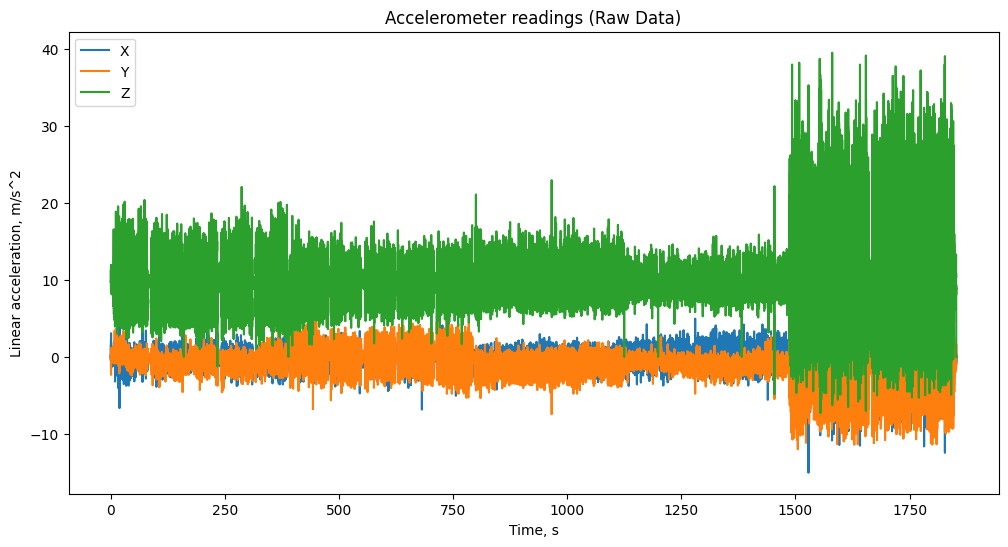

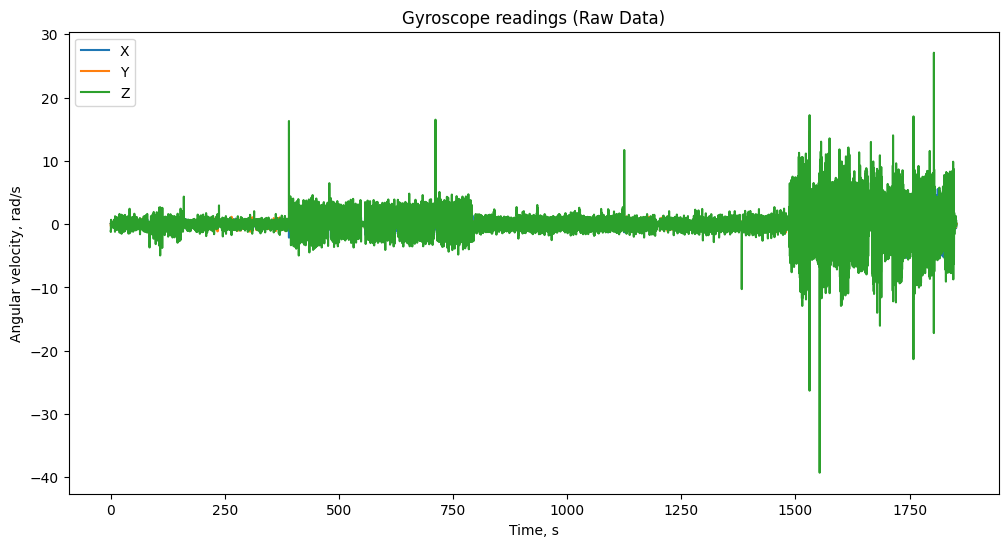

In [8]:
display_three_axes(df=train_df, x='time', y=['accX', 'accY', 'accZ'], title='Accelerometer readings (Raw Data)', 
                   x_label='Time, s', y_label='Linear acceleration, m/s^2', filename='graphs/squats_acc')
display_three_axes(df=train_df, x='time', y=['gyrX', 'gyrY', 'gyrZ'], title='Gyroscope readings (Raw Data)', 
                   x_label='Time, s', y_label='Angular velocity, rad/s')

#### 3) Save train_df to a separate file

In [ ]:
train_df.to_csv('data/40_Hz/concatenated_data/All/Train_1_2023-08-21.csv', index=False)

In [ ]:
read_train_df = pd.read_csv('data/40_Hz/concatenated_data/All/Train_1_2023-08-21.csv')
read_train_df.head()

## test_df

In [27]:
columns = ['timestamp', 'accX', 'accY', 'accZ', 'gyrX', 'gyrY', 'gyrZ']
test_df = pd.read_csv('data/40_Hz/original_data/test/Test1_HIMU-2023-08-20_09-31-52.csv', names=columns, skiprows=4)

test_df.head()

,timestamp,accX,accY,accZ,gyrX,gyrY,gyrZ
0,1692513112541,0.18195,-0.01395,9.904051,0.024200,0.000550,-0.067650
1,1692513112574,0.18495,0.09000,9.717000,0.009487,-0.031213,0.028325
2,1692513112599,0.18495,0.14505,9.745951,-0.002475,-0.047575,0.090338
3,1692513112631,0.14400,0.13605,9.772051,0.003438,-0.046887,0.097488
4,1692513112660,0.17505,0.06195,10.002001,0.017600,-0.039600,0.078238


In [ ]:
test_df.info()

#### 1) Add 'time' column

In [ ]:
test_df = add_time_column(df=test_df, timestamp_col_name='timestamp', initial_time=0, timecol_position=1)
test_df.head()

In [ ]:
test_df[-1:]

In [ ]:
time_diffs = test_df['time'].diff()
measurement_time = test_df['time'].iloc[-1] - test_df['time'].iloc[0]
print(f"measurement_time = {measurement_time} s")
print(f"Average measurement period = {time_diffs.mean()} s")
print(f"Average measurement frequency = {1 / time_diffs.mean()} Hz")

#### 2) Visualise accelerometer and gyroscope behaviour (Raw data)

In [ ]:
display_three_axes(df=test_df, x='time', y=['accX', 'accY', 'accZ'], title='Accelerometer readings (Raw Data)', 
                   x_label='Time, s', y_label='Linear acceleration, m/s^2')
display_three_axes(df=test_df, x='time', y=['gyrX', 'gyrY', 'gyrZ'], title='Gyroscope readings (Raw Data)', 
                   x_label='Time, s', y_label='Angular velocity, rad/s')

#### 3) Save test_df to a separate file

In [ ]:
test_df.to_csv('data/40_Hz/concatenated_data/All/Test_1_2023-08-23.csv', index=False)

In [ ]:
read_test_df = pd.read_csv('data/40_Hz/concatenated_data/All/Test_1_2023-08-23.csv')
read_test_df.head()

## train_activities_df

In [ ]:
labels_df = create_activities_df(path='data/40_Hz/labeled_data/Train_test_1_labeled_1.csv', row_index=0)
labels_df

In [20]:
df = pd.read_csv('data/40_Hz/concatenated_data/All/Train_1_2023-08-21.csv')
df.head()

,timestamp,time,accX,accY,accZ,gyrX,gyrY,gyrZ
0,1692440406933,0.000,0.14895,-0.06000,9.775050,0.106150,-0.018975,-1.117325
1,1692440406976,0.043,-0.05400,0.04200,9.748950,0.110550,-0.163075,-1.241488
2,1692440407003,0.070,0.23295,-0.12405,9.739051,0.096937,-0.311437,-1.159812
3,1692440407037,0.104,-0.18495,-0.01200,9.691051,0.079475,-0.309375,-0.900900
4,1692440407057,0.124,-0.46305,0.13605,10.146001,0.065037,-0.293013,-0.771787


In [ ]:
add_activity_column(path='data/40_Hz/labeled_data/Train_test_1_labeled_1.csv', df=df, df_merge_col='time', row_index=0)
df.head()

### Check that the 'activity' column is filled in correctly

In [ ]:
df[df['time'] > 4.730][:5]

In [ ]:
df[df['time'] > 79.900][:5]

In [ ]:
df[df['time'] > 87.200][:5]

In [ ]:
df[df['time'] > 627.850][:5]

In [ ]:
df[df['time'] > 798.500][:5]

In [ ]:
df[df['time'] > 1667.950][:5]

In [ ]:
df[df['time'] > 1847.925][:5]

### Save train_activities_df to a separate file

In [ ]:
df.to_csv('data/40_Hz/concatenated_data/All/Train_activities_1_2023-08-23.csv', index=False)

## test_activities_df

In [ ]:
test_labels_df = create_activities_df(path='data/40_Hz/labeled_data/Train_test_1_labeled_1.csv', row_index=1)
test_labels_df

In [29]:
test_df = pd.read_csv('data/40_Hz/concatenated_data/All/Test_1_2023-08-23.csv')
test_df.head()

,timestamp,time,accX,accY,accZ,gyrX,gyrY,gyrZ
0,1692513112541,0.000,0.18195,-0.01395,9.904051,0.024200,0.000550,-0.067650
1,1692513112574,0.033,0.18495,0.09000,9.717000,0.009487,-0.031213,0.028325
2,1692513112599,0.058,0.18495,0.14505,9.745951,-0.002475,-0.047575,0.090338
3,1692513112631,0.090,0.14400,0.13605,9.772051,0.003438,-0.046887,0.097488
4,1692513112660,0.119,0.17505,0.06195,10.002001,0.017600,-0.039600,0.078238


In [ ]:
add_activity_column(path='data/40_Hz/labeled_data/Train_test_1_labeled_1.csv', df=test_df, df_merge_col='time', row_index=1)
test_df.head()

### Check that the 'activity' column is filled in correctly

In [ ]:
test_df[test_df['time'] > 3.220][:5]

In [ ]:
test_df[test_df['time'] > 39.1][:5]

In [ ]:
test_df[test_df['time'] > 48.4][:5]

In [ ]:
test_df[test_df['time'] > 275.82][:5]

In [ ]:
test_df[test_df['time'] > 361.58][:5]

### Save test_activities_df to a separate file 

In [ ]:
test_df.to_csv('data/40_Hz/concatenated_data/All/Test_activities_1_2023-08-23.csv', index=False)